In [10]:
# import necessary packages:
import pandas as pd
import numpy as np
import scipy
import math
import matplotlib.pyplot as plt
from sklearn.covariance import GraphLassoCV
from sklearn.metrics import mutual_info_score
from mpl_toolkits.axes_grid1 import make_axes_locatable

# [A] define the methods for functional connectivity:

In [11]:
# [2] define partial correlation through OLS:
from scipy import stats, linalg
def partial_corr(C):
    """
    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
    for the remaining variables in C.
    Parameters
    ----------
    C : array-like, shape (n, p)
        Array with the different variables. Each column of C is taken as a variable
    Returns
    -------
    P : array-like, shape (p, p)
        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
        for the remaining variables in C.
    """

    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]

            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)

            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr

    return P_corr

In [1]:
# [3] define measures of similarity:
def euclidean_distance(x,y): 
    """Returns euclidean distance between two lists or numpy arrays"""
    x = np.array(x)
    y = np.array(y)
    return np.sqrt(sum((x-y)**2))
 
def manhattan_distance(x,y): 
    """Returns manhattan distance between two lists or numpy arrays"""
    x = np.array(x)
    y = np.array(y)
    return sum(abs(x - y))

In [13]:
# [4] MUTUAL INFORMATION:
from sklearn.metrics import mutual_info_score

import numpy as np

def calc_MI(X,Y,bins):
   c_XY = np.histogram2d(X,Y,bins)[0]
   c_X = np.histogram(X,bins)[0]
   c_Y = np.histogram(Y,bins)[0]

   H_X = shan_entropy(c_X)
   H_Y = shan_entropy(c_Y)
   H_XY = shan_entropy(c_XY)

   MI = H_X + H_Y - H_XY
   return MI

def shan_entropy(c):
    c_normalized = c / float(np.sum(c))
    c_normalized = c_normalized[np.nonzero(c_normalized)]
    H = -sum(c_normalized* np.log2(c_normalized))  
    return H

# [B] compute functional connectivity on the resting state dataset, with the aforementioned methods:

In [14]:
# load the fMRI data:
df1    = pd.read_csv("100307_restingstate_day1.csv")
data1  = df1.values
Nvars  = data1.shape[1]

labels_Glasser  = pd.read_csv("labels_Glasser.csv",header=None)[0].tolist()

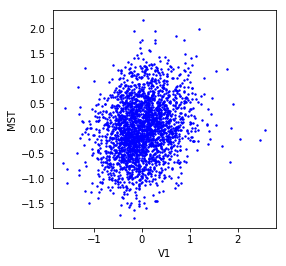

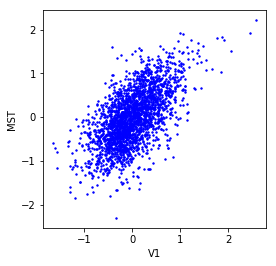

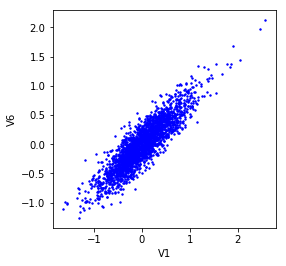

In [15]:
# check the linearity between variables:
plt.figure(figsize=(4,4))
plt.scatter(data1[:,0], data1[:,1], color='b', s=2)
plt.xlabel(labels_Glasser[0])
plt.ylabel(labels_Glasser[1])
plt.show()

plt.figure(figsize=(4,4))
plt.scatter(data1[:,0], data1[:,2], color='b', s=2)
plt.xlabel(labels_Glasser[0])
plt.ylabel(labels_Glasser[1])
plt.show()

plt.figure(figsize=(4,4))
plt.scatter(data1[:,0], data1[:,3], color='b', s=2)
plt.xlabel(labels_Glasser[0])
plt.ylabel(labels_Glasser[2])
plt.show()

In [ ]:
# shorten the datasets to 800 samples, in order to make them comparable with the visual stimulation task if necessary:
# list1 = np.ndarray.tolist(np.arange(400))
# list2 = np.ndarray.tolist(1200+np.arange(400))
# indexes = list(itertools.chain(list1, list2)) 
# data1 = data1[indexes,:]

In [19]:
import itertools

# [1] PEARSON'S R:
pearsonr        = np.zeros((Nvars,Nvars))
pearsonr_p      = np.zeros((Nvars,Nvars))
for ind1 in range(Nvars):
    for ind2 in range(Nvars):
        (pearsonr[ind1,ind2],pearsonr_p[ind1,ind2]) = scipy.stats.pearsonr(data1[:,ind1], data1[:,ind2])

# [2A] PARTIAL CORRELATION THROUGH OLS REGRESSION:
# warning: this one is slooooow:
# partial_correlation1 = partial_corr(data)

# [2B] PARTIAL CORRELATION THROUGH INVERSE COVARIANCE:
# partial_correlation = partial_corr(data)
covariance_matrix = np.cov(np.transpose(data1))
inv_cov = np.linalg.inv(covariance_matrix)
partial_correlation2 = np.zeros((Nvars,Nvars))
for ind1 in range(Nvars):
    for ind2 in range(Nvars):
        partial_correlation2[ind1,ind2] = - inv_cov[ind1,ind2]/np.sqrt((inv_cov[ind1,ind1])*(inv_cov[ind2,ind2]))
        
# [3] MEASURES OF SIMILARITY:
euclidean = np.zeros((Nvars,Nvars))
for ind1 in range(Nvars):
    for ind2 in range(Nvars):
        euclidean[ind1,ind2] = euclidean_distance(data1[:,ind1], data1[:,ind2])

manhattan = np.zeros((Nvars,Nvars))
for ind1 in range(Nvars):
    for ind2 in range(Nvars):
        manhattan[ind1,ind2] = manhattan_distance(data1[:,ind1], data1[:,ind2])

# [4] MUTUAL INFORMATION:        
# you need to specify the number of bins (which is a shortcoming of mutual information):
bins = 10
matMI = np.zeros((Nvars,Nvars))

for ix in np.arange(Nvars):
    for jx in np.arange(ix+1,Nvars):
        matMI[ix,jx] = calc_MI(data1[:,ix], data1[:,jx], bins)
        matMI[jx,ix] = matMI[ix,jx]

In [ ]:
# [C] plot the functional connectomes:

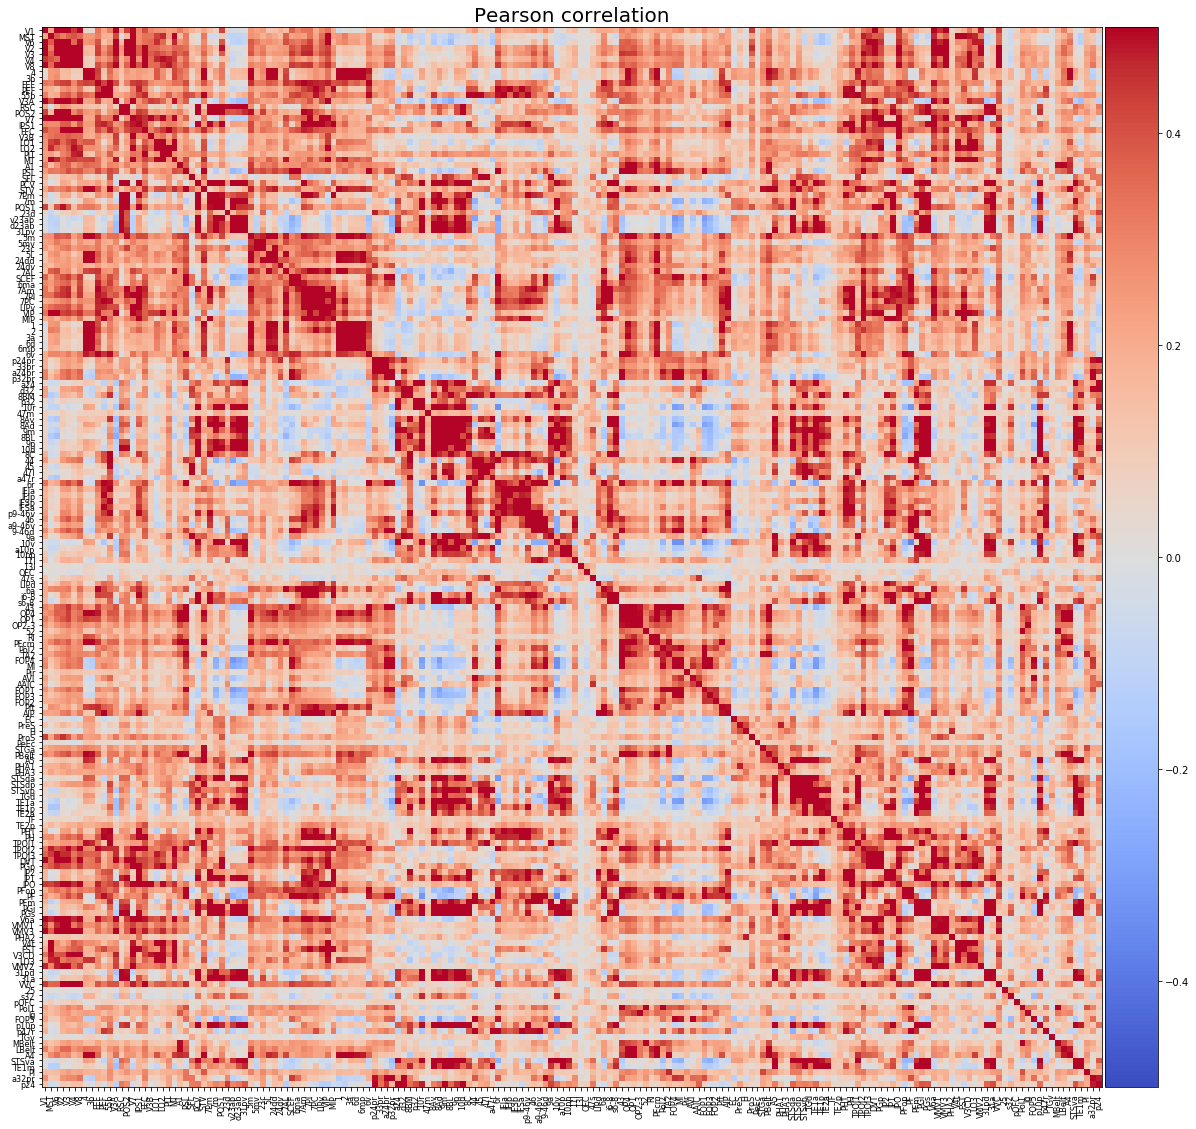

In [62]:
# [1] PEARSON'S R:
f = plt.figure(figsize=(20,20))
ax = plt.gca()
im = plt.imshow(pearsonr, clim=[-0.5,0.5],cmap='coolwarm')
plt.xticks(np.arange(len(labels_Glasser)), labels_Glasser, rotation='vertical', fontsize=8)
plt.yticks(np.arange(len(labels_Glasser)), labels_Glasser, fontsize=8)
plt.title('Pearson correlation', fontsize=20)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

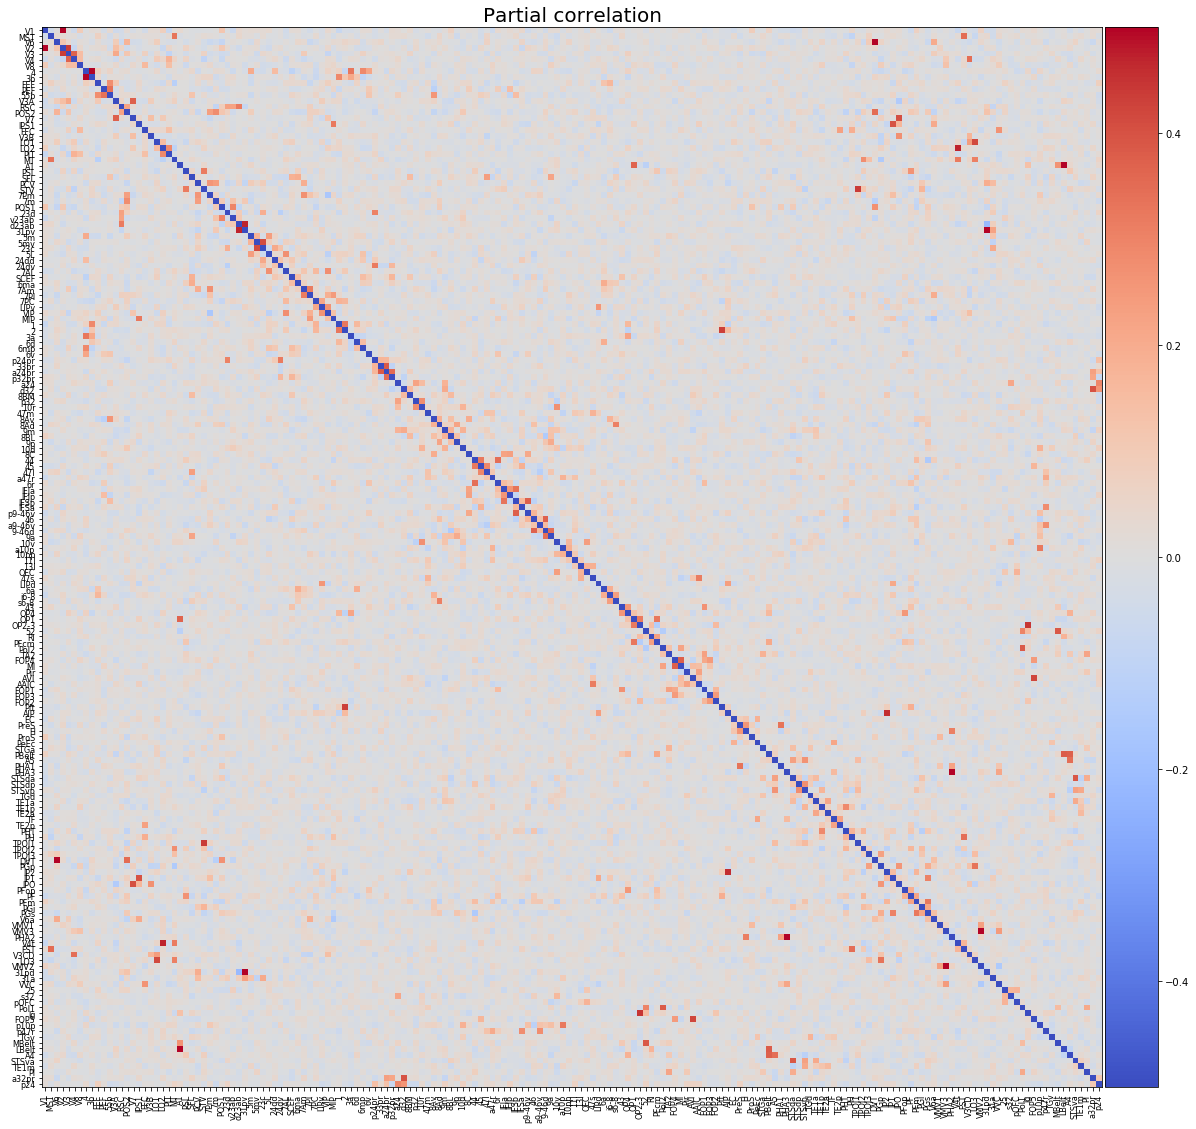

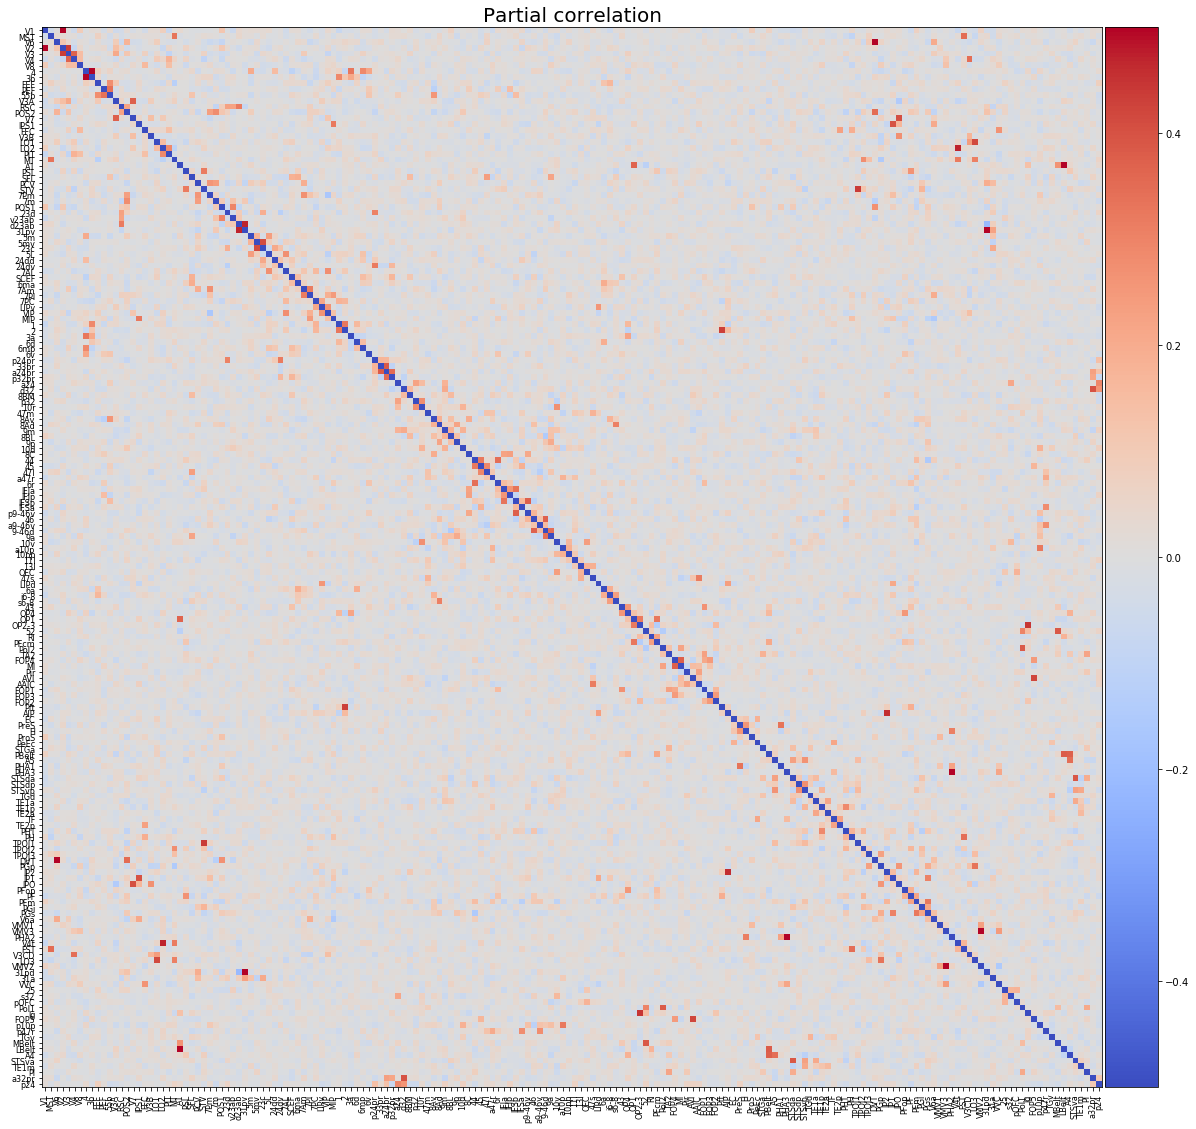

In [61]:
#[2B] PARTIAL CORRELATION THROUGH INVERSE COVARIANCE:
f = plt.figure(figsize=(20,20))
ax = plt.gca()
im = plt.imshow(partial_correlation2, clim=[-0.5,0.5],cmap='coolwarm')
plt.xticks(np.arange(len(labels_Glasser)), labels_Glasser, rotation='vertical', fontsize=8)
plt.yticks(np.arange(len(labels_Glasser)), labels_Glasser, fontsize=8)
plt.title('Partial correlation through inverse covariance', fontsize=20)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

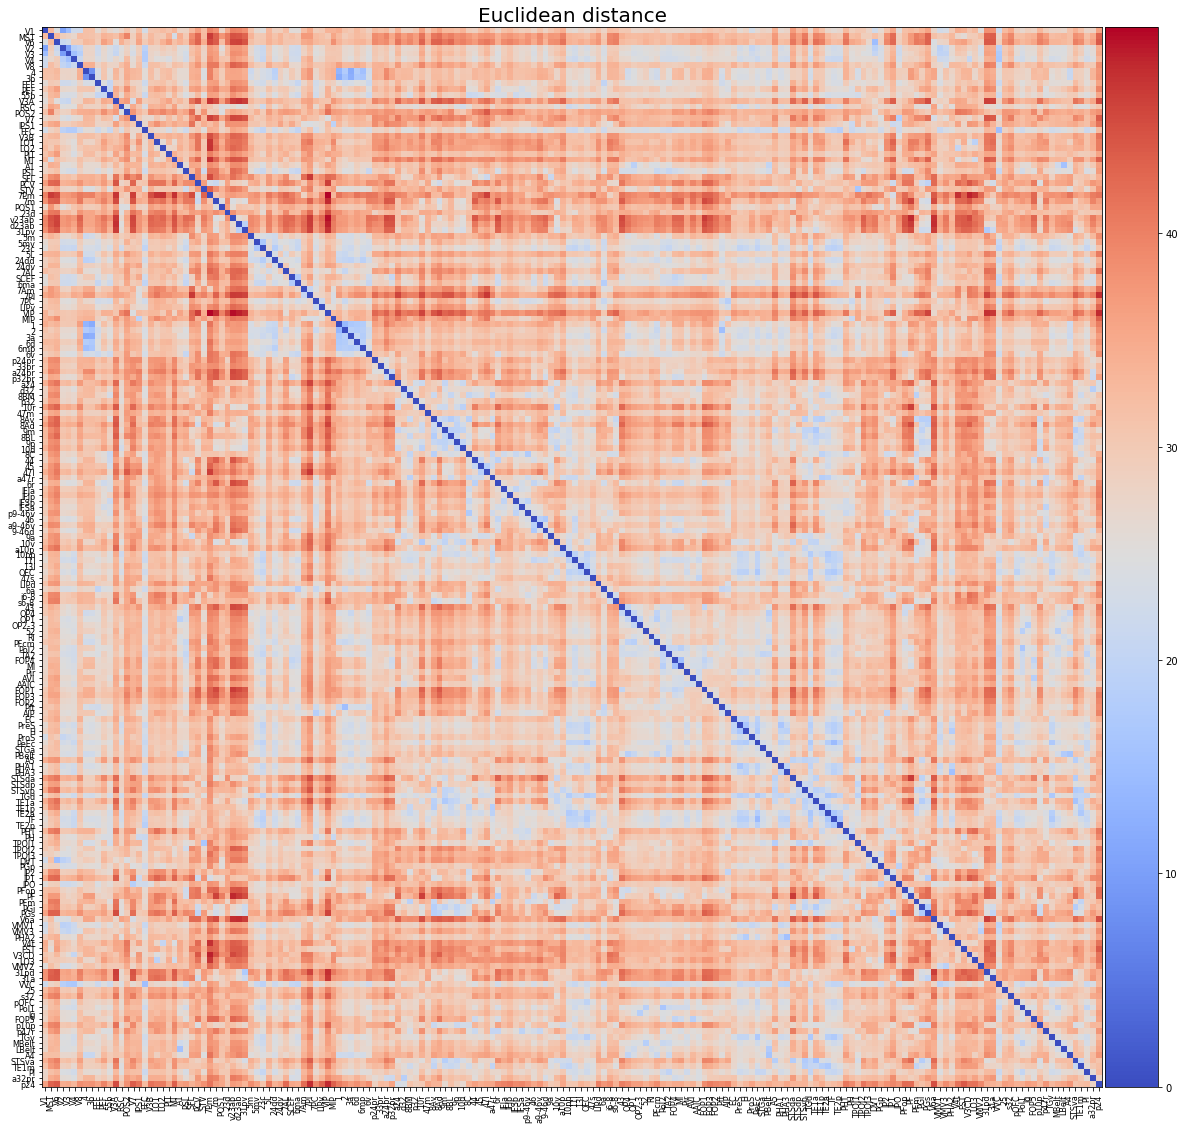

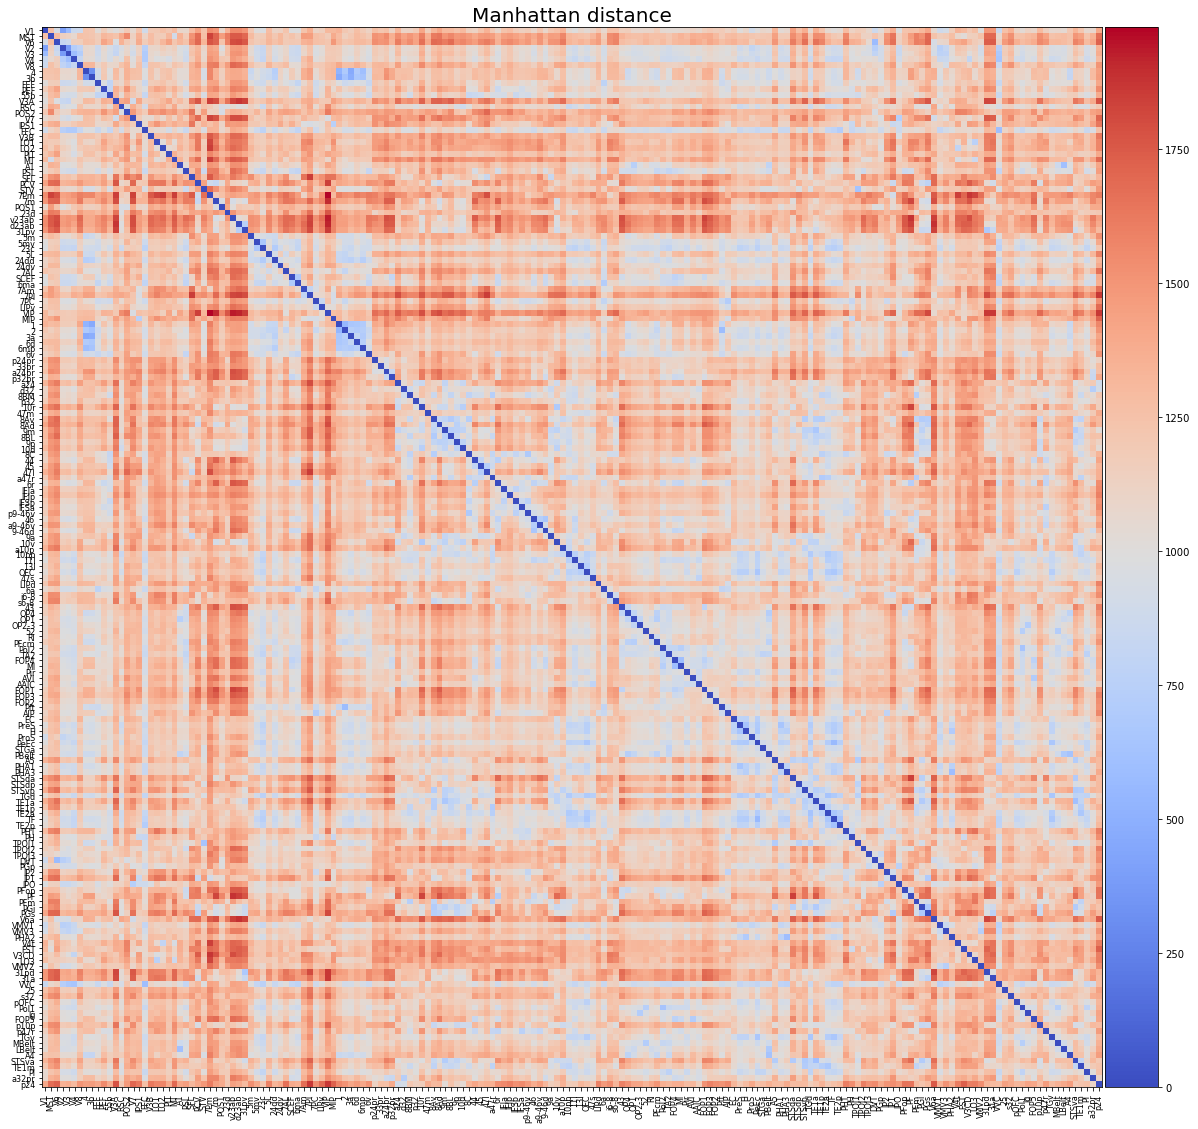

In [64]:
# [C] MEASURES OF SIMILARITY:
f = plt.figure(figsize=(20,20))
ax = plt.gca()
im = plt.imshow(euclidean, cmap='coolwarm')
plt.xticks(np.arange(len(labels_Glasser)), labels_Glasser, rotation='vertical', fontsize=8)
plt.yticks(np.arange(len(labels_Glasser)), labels_Glasser, fontsize=8)
plt.title('Euclidean distance', fontsize=20)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()


f = plt.figure(figsize=(20,20))
ax = plt.gca()
im = plt.imshow(manhattan, cmap='coolwarm')
plt.xticks(np.arange(len(labels_Glasser)), labels_Glasser, rotation='vertical', fontsize=8)
plt.yticks(np.arange(len(labels_Glasser)), labels_Glasser, fontsize=8)
plt.title('Manhattan distance', fontsize=20)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

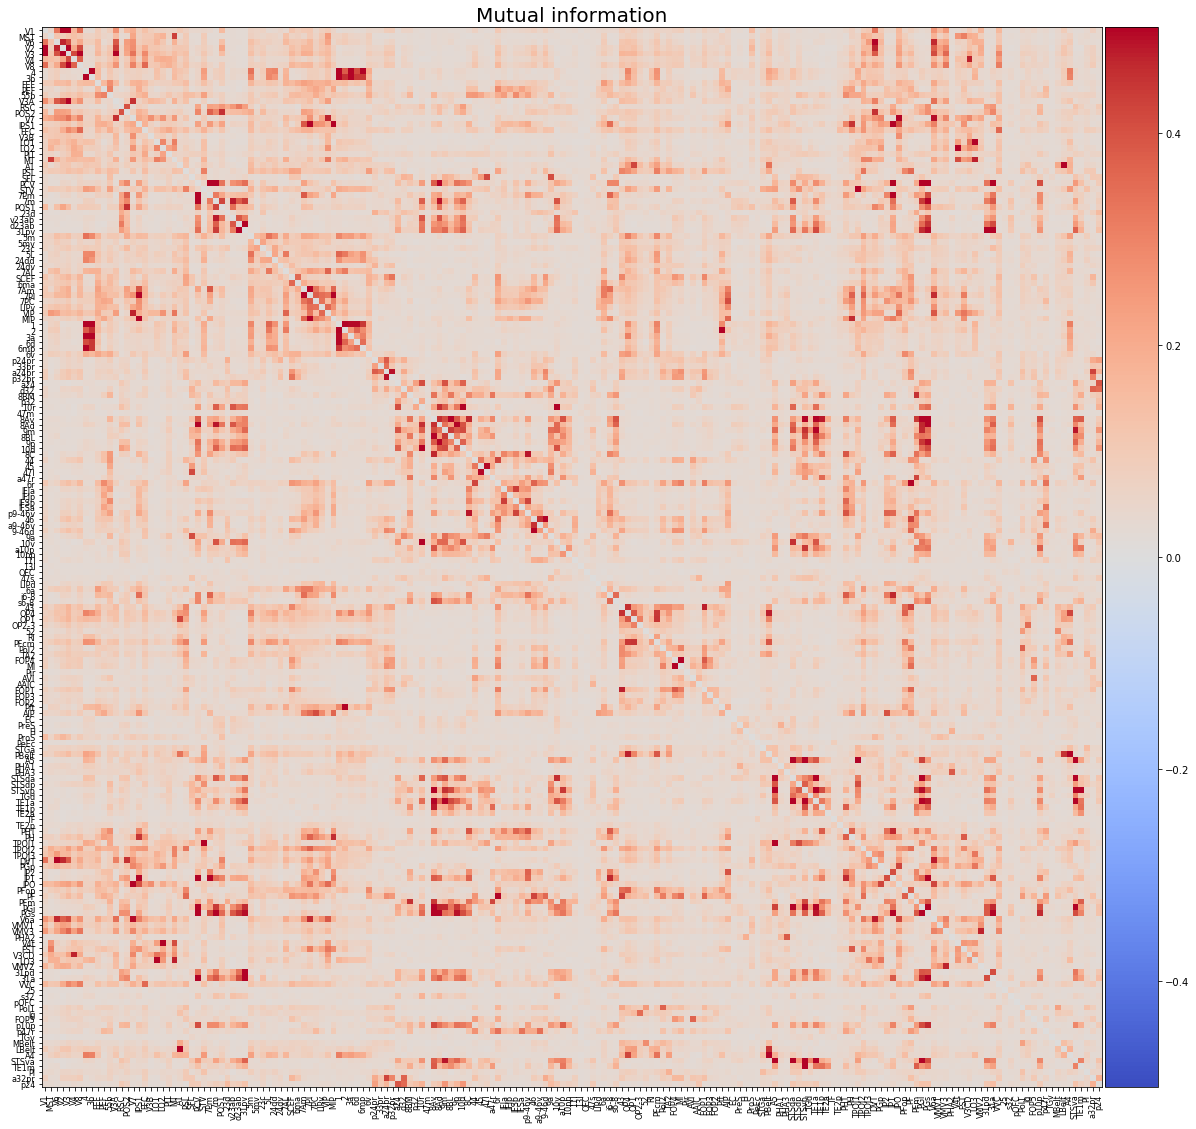

In [67]:
# [4] MUTUAL INFORMATION:
f = plt.figure(figsize=(20,20))
ax = plt.gca()
im = plt.imshow(matMI, clim=[-0.5,0.5],cmap='coolwarm')
plt.xticks(np.arange(len(labels_Glasser)), labels_Glasser, rotation='vertical', fontsize=8)
plt.yticks(np.arange(len(labels_Glasser)), labels_Glasser, fontsize=8)
plt.title('Mutual information', fontsize=20)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

In [79]:
# [D] partial correlation between between two participnats, 
# and between resting state, two days of scanning and the visual working memory task:
# load the fMRI data:
list1 = np.ndarray.tolist(np.arange(400))
list2 = np.ndarray.tolist(1200+np.arange(400))

import itertools
indexes = list(itertools.chain(list1, list2)) #list(set(indexes_female + indexes_male_matched))


df2    = pd.read_csv("100307_restingstate_day2.csv")
data2  = df2.values
data2  = data2[indexes,:]

df3    = pd.read_csv("100307_WMtask.csv")
data3  = df3.values

df4    = pd.read_csv("100408_restingstate_day1.csv")
data4  = df4.values
data4  = data4[indexes,:]

df5    = pd.read_csv("100408_restingstate_day2.csv")
data5  = df5.values
data5  = data5[indexes,:]

df6    = pd.read_csv("100408_WMtask.csv")
data6  = df6.values

pearsonr_data2 = np.zeros((Nvars,Nvars))
pearsonr_p_data2 = np.zeros((Nvars,Nvars))
for ind1 in range(Nvars):
    for ind2 in range(Nvars):
        (pearsonr_data2[ind1,ind2],pearsonr_p_data2[ind1,ind2]) = scipy.stats.pearsonr(data2[:,ind1], data2[:,ind2])

pearsonr_data3 = np.zeros((Nvars,Nvars))
pearsonr_p_data3 = np.zeros((Nvars,Nvars))
for ind1 in range(Nvars):
    for ind2 in range(Nvars):
        (pearsonr_data3[ind1,ind2],pearsonr_p_data3[ind1,ind2]) = scipy.stats.pearsonr(data3[:,ind1], data3[:,ind2]) 
        
pearsonr_data4 = np.zeros((Nvars,Nvars))
pearsonr_p_data4 = np.zeros((Nvars,Nvars))
for ind1 in range(Nvars):
    for ind2 in range(Nvars):
        (pearsonr_data4[ind1,ind2],pearsonr_p_data4[ind1,ind2]) = scipy.stats.pearsonr(data4[:,ind1], data4[:,ind2])

pearsonr_data5 = np.zeros((Nvars,Nvars))
pearsonr_p_data5 = np.zeros((Nvars,Nvars))
for ind1 in range(Nvars):
    for ind2 in range(Nvars):
        (pearsonr_data5[ind1,ind2],pearsonr_p_data5[ind1,ind2]) = scipy.stats.pearsonr(data5[:,ind1], data5[:,ind2]) 

pearsonr_data6 = np.zeros((Nvars,Nvars))
pearsonr_p_data6 = np.zeros((Nvars,Nvars))
for ind1 in range(Nvars):
    for ind2 in range(Nvars):
        (pearsonr_data6[ind1,ind2],pearsonr_p_data6[ind1,ind2]) = scipy.stats.pearsonr(data6[:,ind1], data6[:,ind2]) 

(799, 180)


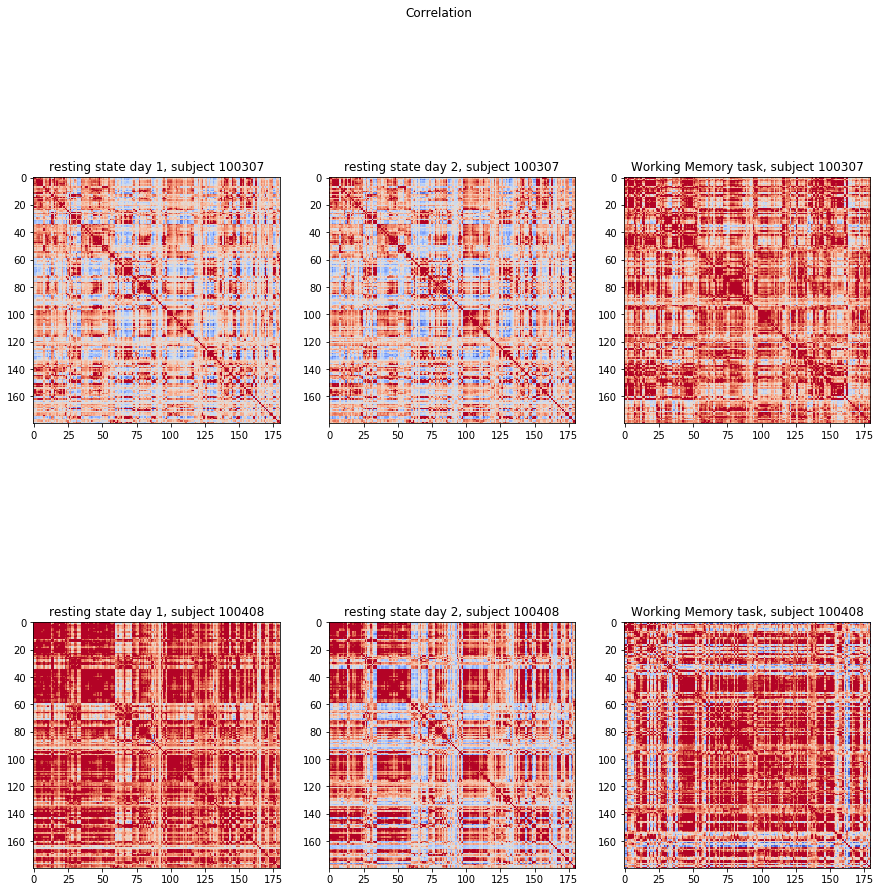

In [120]:
f, axarr = plt.subplots(2,3,figsize=(15,15))
plt.suptitle('Correlation')
axarr[0, 0].imshow(pearsonr, cmap='coolwarm', clim=[-0.5,0.5])
axarr[0, 0].set_title('resting state day 1, subject 100307')
axarr[0, 1].imshow(pearsonr_data2, cmap='coolwarm', clim=[-0.5,0.5])
axarr[0, 1].set_title('resting state day 2, subject 100307')
axarr[0, 2].imshow(pearsonr_data3, cmap='coolwarm', clim=[-0.5,0.5])
axarr[0, 2].set_title('Working Memory task, subject 100307')
axarr[1, 0].imshow(pearsonr_data4, cmap='coolwarm', clim=[-0.5,0.5])
axarr[1, 0].set_title('resting state day 1, subject 100408')
axarr[1, 1].imshow(pearsonr_data5, cmap='coolwarm', clim=[-0.5,0.5])
axarr[1, 1].set_title('resting state day 2, subject 100408')
axarr[1, 2].imshow(pearsonr_data6, cmap='coolwarm', clim=[-0.5,0.5])
axarr[1, 2].set_title('Working Memory task, subject 100408')
plt.show()

In [121]:
# the same for partial correlation:
# comparison between between two participants, and between resting state, two days of scanning and the visual working memory task:
# load the fMRI data:

covariance_matrix_data1 = np.cov(np.transpose(data1))
inv_cov_data1 = np.linalg.inv(covariance_matrix_data1)
partial_correlation_data1 = np.zeros((Nvars,Nvars))
for ind1 in range(Nvars):
    for ind2 in range(Nvars):
        partial_correlation_data1[ind1,ind2] = - inv_cov_data1[ind1,ind2]/np.sqrt((inv_cov_data1[ind1,ind1])*(inv_cov_data1[ind2,ind2]))

covariance_matrix_data2 = np.cov(np.transpose(data2))
inv_cov_data2 = np.linalg.inv(covariance_matrix_data2)
partial_correlation_data2 = np.zeros((Nvars,Nvars))
for ind1 in range(Nvars):
    for ind2 in range(Nvars):
        partial_correlation_data2[ind1,ind2] = - inv_cov_data2[ind1,ind2]/np.sqrt((inv_cov_data2[ind1,ind1])*(inv_cov_data2[ind2,ind2]))

covariance_matrix_data3 = np.cov(np.transpose(data3))
inv_cov_data3 = np.linalg.inv(covariance_matrix_data3)
partial_correlation_data3 = np.zeros((Nvars,Nvars))
for ind1 in range(Nvars):
    for ind2 in range(Nvars):
        partial_correlation_data3[ind1,ind2] = - inv_cov_data3[ind1,ind2]/np.sqrt((inv_cov_data3[ind1,ind1])*(inv_cov_data3[ind2,ind2]))

covariance_matrix_data4 = np.cov(np.transpose(data4))
inv_cov_data4 = np.linalg.inv(covariance_matrix_data4)
partial_correlation_data4 = np.zeros((Nvars,Nvars))
for ind1 in range(Nvars):
    for ind2 in range(Nvars):
        partial_correlation_data4[ind1,ind2] = - inv_cov_data4[ind1,ind2]/np.sqrt((inv_cov_data4[ind1,ind1])*(inv_cov_data4[ind2,ind2]))

covariance_matrix_data5 = np.cov(np.transpose(data5))
inv_cov_data5 = np.linalg.inv(covariance_matrix_data5)
partial_correlation_data5 = np.zeros((Nvars,Nvars))
for ind1 in range(Nvars):
    for ind2 in range(Nvars):
        partial_correlation_data5[ind1,ind2] = - inv_cov_data5[ind1,ind2]/np.sqrt((inv_cov_data5[ind1,ind1])*(inv_cov_data5[ind2,ind2]))

covariance_matrix_data6 = np.cov(np.transpose(data6))
inv_cov_data6 = np.linalg.inv(covariance_matrix_data6)
partial_correlation_data6 = np.zeros((Nvars,Nvars))
for ind1 in range(Nvars):
    for ind2 in range(Nvars):
        partial_correlation_data6[ind1,ind2] = - inv_cov_data6[ind1,ind2]/np.sqrt((inv_cov_data6[ind1,ind1])*(inv_cov_data6[ind2,ind2]))


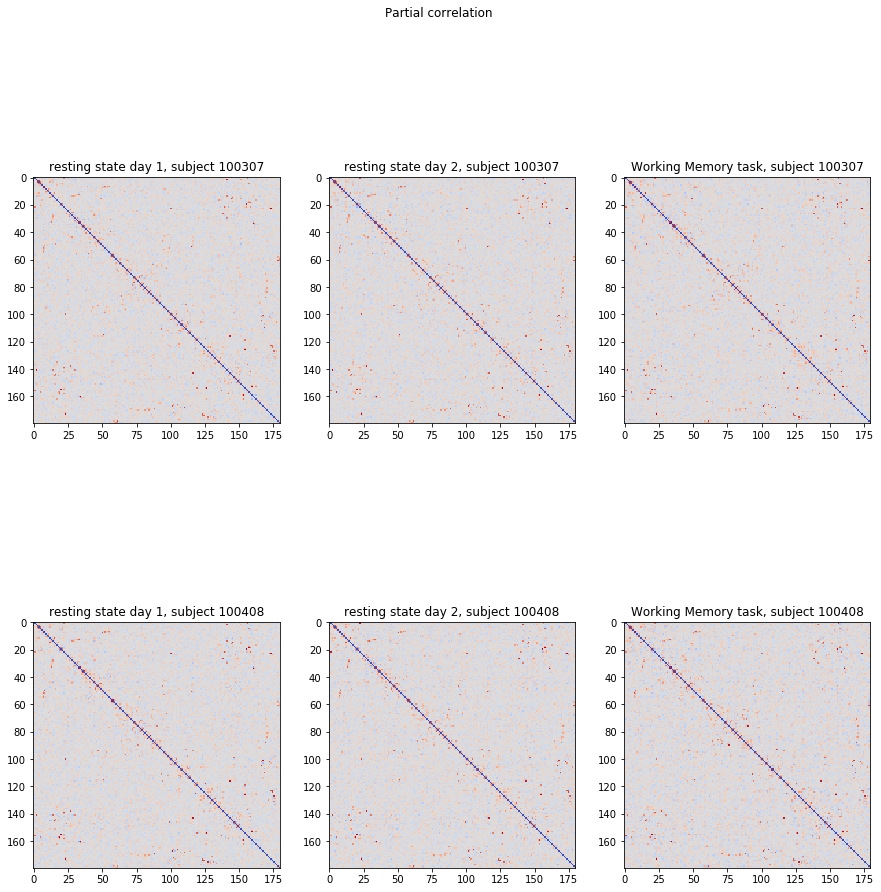

In [95]:
f, axarr = plt.subplots(2,3,figsize=(15,15))
plt.suptitle('Partial correlation')
axarr[0, 0].imshow(partial_correlation_data1, cmap='coolwarm', clim=[-0.5,0.5])
axarr[0, 0].set_title('resting state day 1, subject 100307')
axarr[0, 1].imshow(partial_correlation_data2, cmap='coolwarm', clim=[-0.5,0.5])
axarr[0, 1].set_title('resting state day 2, subject 100307')
axarr[0, 2].imshow(partial_correlation_data3, cmap='coolwarm', clim=[-0.5,0.5])
axarr[0, 2].set_title('Working Memory task, subject 100307')
axarr[1, 0].imshow(partial_correlation_data4, cmap='coolwarm', clim=[-0.5,0.5])
axarr[1, 0].set_title('resting state day 1, subject 100408')
axarr[1, 1].imshow(partial_correlation_data5, cmap='coolwarm', clim=[-0.5,0.5])
axarr[1, 1].set_title('resting state day 2, subject 100408')
axarr[1, 2].imshow(partial_correlation_data6, cmap='coolwarm', clim=[-0.5,0.5])
axarr[1, 2].set_title('Working Memory task, subject 100408')
plt.show()

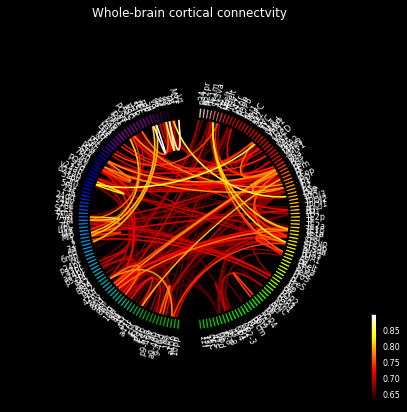

In [106]:
# [E] plot circular connectomes:
# on the basis of online tutorial:
# https://www.martinos.org/mne/stable/auto_examples/connectivity/plot_mne_inverse_label_connectivity.html
# https://www.martinos.org/mne/stable/generated/mne.viz.plot_connectivity_circle.html#mne.viz.plot_connectivity_circle
    
import mne
from mne.datasets import sample
from mne.minimum_norm import apply_inverse_epochs, read_inverse_operator
from mne.connectivity import spectral_connectivity
from mne.viz import circular_layout, plot_connectivity_circle

label_names = labels_Glasser
node_order = []
node_order.extend(labels_Glasser)

node_angles = circular_layout(label_names, node_order, start_pos=90,
                              group_boundaries=[0, len(label_names) / 2])

# Plot the graph using node colors from the FreeSurfer parcellation. We only
# show the 300 strongest connections.
plot_connectivity_circle(pearsonr, label_names, n_lines=300, colorbar=True,
                         node_angles=node_angles, #node_colors=label_colors,
                         title='Whole-brain cortical connectvity')
plt.show()